# Gradient Descent Without Gradients

In the last post I introduced Gradient Descent, and used it to a simple linear regression in 1 dimension. The function that did most of the work was:

In [4]:
def gradient_descent(X, y, cost, learning_rate=0.01, num_iters=250):
    m, n = X.shape
    theta = np.zeros((n, 1))
    yhat = theta.T @ X.T
    yield theta, cost(y.reshape(-1, 1), yhat.T)
    
    for i in range(num_iters):
        yhat = theta.T @ X.T
        yhatt = yhat.T
        nabla = np.sum(X.T @ (y.reshape(-1, 1) - yhatt), axis=1).reshape(-1, 1)
        assert(nabla.shape == theta.shape)
        theta +=  (2 * learning_rate / m) * nabla
        yield theta, cost(y.reshape(-1, 1), yhat.T)

However, this function has a drawback - it only works for linear regression. In this post we'll modify the function to take other losses and perform gradient descent automatically. Let's first generate some toy data:

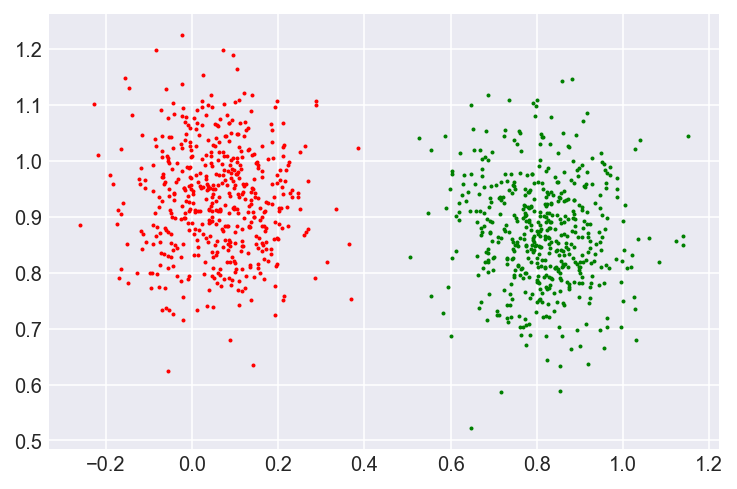

In [5]:
import autograd.numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

def make_blobs(num_samples=1000, num_features=2, num_classes=2):
    mu = np.random.rand(num_classes, num_features)
    sigma = np.ones((num_classes, num_features)) * 0.1
    samples_per_class = num_samples // num_classes
    x = np.zeros((num_samples, num_features))
    y = np.zeros((num_samples, num_classes))
    for i in range(num_classes):
        class_samples = np.random.normal(mu[i, :], sigma[i, :], (samples_per_class, num_features))
        x[i * samples_per_class:(i+1) * samples_per_class] = class_samples
        y[i * samples_per_class:(i+1) * samples_per_class, i] = 1
    return x, y
    

def plot_clusters(x, y, num_classes=2):
    temp = np.argmax(y, axis=1)
    colours = ['r', 'g', 'b']
    for i in range(num_classes):
        x_class = x[temp == i]
        plt.scatter(x_class[:, 0], x_class[:, 1], color=colours[i], s=1)
    plt.show()

NUM_FEATURES=50
NUM_CLASSES=2
NUM_SAMPLES=1000

X, y, = make_blobs(num_samples=NUM_SAMPLES, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)
plot_clusters(X, y, num_classes=NUM_CLASSES)

In [6]:
X

array([[-0.05461888,  0.93787102, -0.09551936, ...,  0.02657511,
         0.72509201,  0.68530672],
       [-0.09366208,  0.7994963 ,  0.008594  , ...,  0.12660328,
         0.60329672,  0.66772192],
       [ 0.13367689,  0.81014452, -0.10304008, ...,  0.15666234,
         0.71245837,  0.57504779],
       ..., 
       [ 0.9828324 ,  0.82414756,  0.55084061, ...,  0.23759356,
         1.06799085,  0.56271078],
       [ 0.77171086,  0.93970304,  0.37411522, ...,  0.04376771,
         0.95470468,  0.43622007],
       [ 0.8846701 ,  0.89806374,  0.35203692, ...,  0.09546763,
         1.09566046,  0.5202908 ]])

We'll predict the class of each point using softmax (multinomial logistic) regression. The model has a matrix $ W $ of weights, which measures for each feature how likely that feature is to be in a particular. It is of size $ \mathrm{n_{features}} \times \mathrm{n_{classes}} $. The goal of softmax regression is to learn such a matrix. Given a matrix of weights, $ W $, and matrix of points, $ X $, it predicts the probability od each class given the samples

$$ p\left( y_i | x_i ; w \right) = \frac{e^{w_j^T x_i}}{\sum_j e^{w_j^T x_i}}$$

This prediction is encapsulated in the following function:

In [23]:
def sigmoid(x):
    prob = 1.0 / (1.0 + np.exp(-x))
    return prob

def predict(w, x):
    return sigmoid(np.dot(x, w))

To get a feel we'll make a random guess:

In [24]:
weights = np.random.randn(NUM_FEATURES, NUM_CLASSES)
y_pred = predict(weights, X)

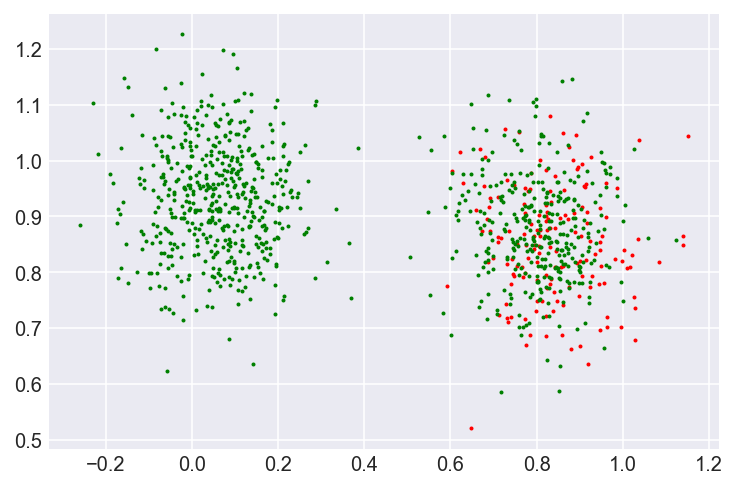

In [25]:
plot_clusters(X, y_pred, NUM_CLASSES)

As you can see, that looks nothing like the real clusters!

Logistic regression minimises the following loss function:

$$ J\left(w\right) = y * p\left( y_i | x_i ; w \right) + (1-y) * (1 - p\left( y_i | x_i ; w \right)) $$

There is a mathematical justification for why this is the right loss to use, but heuristically, this loss minimises the probability error between the predicition classes and the true classes.

In python, the loss can be written:

In [26]:
def loss(weights, inputs, targets):
    num_samples = inputs.shape[0]
    y_pred = predict(weights, inputs)
    label_probabilities = y_pred * targets + (1 - y_pred) * (1 - targets)
    return -np.sum(np.log(label_probabilities))

In [27]:
loss(weights, X, y)

4750.573533547572

We're now in a position to do gradient descent!

In [28]:
from autograd import grad
gradient = grad(loss)

In [29]:
def gradient_descent_auto(X, y, cost, num_classes=2, learning_rate=0.001, num_iters=20):
    from autograd import grad
    num_samples, num_features = X.shape
    weights = np.zeros((num_features, num_classes))
    gradient = grad(cost)
    yield weights, cost(weights, X, y)
    
    for i in range(num_iters):
        nabla = gradient(weights, X, y)
        weights = weights - learning_rate * nabla
        yield weights, cost(weights, X, y)

In [30]:
weights = gradient_descent_auto(X, y, loss, learning_rate=0.001, num_classes=NUM_CLASSES)
w = list(weights)
costs = [x[1] for x in w]

In [31]:
predictions = predict(w[-1][0], X)

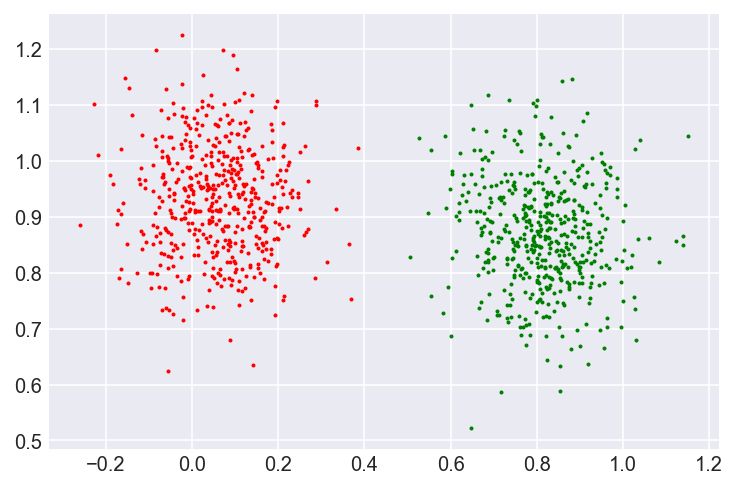

In [32]:
plot_clusters(X, predictions, NUM_CLASSES)

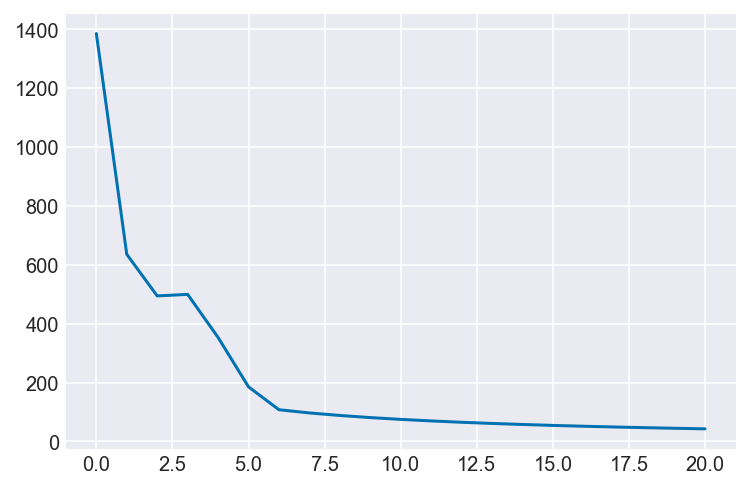

In [33]:
plt.plot(costs)